In [1]:
import numpy
import matplotlib.pyplot as pyplot
import Spectra_Tools as spec
import time

# Rydberg Fluorescence Simulation

Many Rydberg states emit fluorescence in the visible, making them ideal for visualising external fields for example THz fields [[1,2,3]](#References). In order to inform the choice of atom or atomic transition it is helpful to be able to predict the spectrum of fluorescence emitted by a specific Rydberg state. The functions in the `Spectra_Tools` module enable a Monte-Carlo simulation of population randomly decaying out of the specified state to be performed. At every step any emitted photon that is within the specified range of interest is recorded and a spectrum returned. This can be quite time consuming and requires some set-up beforehand.

All of these codes are built on ARC [(Alkali Rydberg Calculator)](https://arc-alkali-rydberg-calculator.readthedocs.io/en/latest/), and I cannot be held responsible for any errors therein.

## Creating Look-Up Tables (LUTs)

To decide where the decays end up based on random number generation, we need to know the probabilities/rates of each possible decay pathway. To this end we create a look-up table that contains the rate of decay from every state to every other state (within limits of maximum $n$ and $l$ values). This is done via the `make_transrate_LUT` function. This file *must* exist in order to run any Monte-Carlo fluorescence models. Note that it can take some time to run (several minutes) depending on parameters.

The function creates a list of all atomic states within the specified limits and evaluates the rate of transitions between them (in $s^{-1}$) using the ARC `getTransitionRate` function. Since the method in ARC will error if the transition is not dipole allowed (instead of just returning zero) the function first checks this is satisfied. If the transition is not dipole allowed, the returned rate will be exactly zero.  

Args:
 - `atom_type` (str `'Cs'` or `'Rb'`): The atomic species to consider. Default is Cs (caesium), Rb is rubidium 87.
 - `n_max` (float, optional): maximum value of the principal quantum number $n$ to be considered. Default is 80.
 - `l_max` (float, optional): maximum value of the angular momentum quantum number $l$ to be considered. Default is 5, corresponding to $\rm{H}$ states.
 - `temp` (float, optional): temperature in K. Affects the rates of transitions affected by blackbody radiation. Default is 350 K. 
 - `save` (bool, optional): whether the calculated array should be saved automatically. Filename is "Transition_Rates_nmax={n_max}\_temp={temp}K_{atom_type}.csv". Default is `True`.
 - `printing` (bool, optional): Enables print statements to monitor progress. Default is `False`.
 
Returns:
 - `states` (2darray of floats): array of all atomic states with $n\leq n_{\rm{max}}$ and $l\leq l_{\rm{max}}$ in format ($n,l,j$)
 - `rates` (2darray of floats): array of rates (in $s^{-1}$) of each possible transition between states in `states` array. Will be of size $s\times s$ for $s$ states. 

The order in which the rates are given corresponds to the order that the states are in. For example for 3 states $1,2,3$, the rate array will be
$$\begin{pmatrix}
\Gamma_{11} & \Gamma_{12} & \Gamma_{13} \\
\Gamma_{21} & \Gamma_{22} & \Gamma_{23} \\
\Gamma_{31} & \Gamma_{32} & \Gamma_{33}
\end{pmatrix}$$
where $\Gamma_{ij}$ is the rate of the transition $i\rightarrow j$. The array should always be antidiagonal, since $\Gamma_{ii} = 0$. The file will be saved in the format 
$$\begin{pmatrix}
n_1 l_1 j_1 & \Gamma_{11} & \Gamma_{12} & \Gamma_{13} \\
n_2 l_2 j_2 & \Gamma_{21} & \Gamma_{22} & \Gamma_{23} \\
n_3 l_3 j_3 & \Gamma_{31} & \Gamma_{32} & \Gamma_{33}
\end{pmatrix}$$

The higher the principal quantum number that is considered the more accurate the simulation will be, however this comes at an increase in time to create the table. The bare minimum needed would be to set `n_max` to be a little higher than the principal quantum number of the state you are evaluating the spectrum for. So if you were wanting to know the spectrum of fluorescence emitted by the $14\rm{D}_{3/2}$ state, setting `n_max = 16` would give you a reasonable estimate. However, since this table only needs to be evaluated once, it is worth going to higher $n$ (80 or more) to save time overall. 

### Example

Here we'll create the look-up-table for caesium at room temperature (350 K) up to $n=100$ and time how long it takes.

In [2]:
start_time = time.time()
all_states, all_rates = spec.make_transrate_LUT('Cs', n_max = 100, save = 'True', printing = 'True')
end_time = time.time()
print('Time taken: {:.1f} mins'.format((end_time - start_time)/60))

Max. n: 100
Total states: 863
Calculating transitions for state 863 of 863
Time taken: 2.3 mins


As we can see, considering states up to $n=100$ means we have a total of $863^2 = 744,769$ transitions to evaluate! This only takes around 2 minutes on my office desktop, and since this is saved we only need to do this once. This can then be used to evaluate all our fluorescence spectra.

## Simulating Spectra

Once the look-up-table of transition rates has been created, the spectrum can be simulated using the Monte-Carlo approach. This is done via the `calculate_spectrum` function.

Args:
 - `state` (tuple): the state to evaluate the fluorescence spectrum of, in the format $(n,l,j)$.
 - `path_to_LUT` (string, optional): file path of the "Transition_Rates" look-up table. Will be used to load the states and rates arrays. Default is `None` (assumes the file is in the current working directory)
 - `atom_type` (string, optional): `Rb` or `Cs`. Defaults to Cs (caesium), Rb is Rubidium 87.
 - `temp` (float, optional): temperature of the atomic ensemble in Kelvin. *Must* match the temperature used to create the look-up-table. Defaults to 350 K.
 - `nmax` (float, optional): maximum value of n to be considered. *Must* match the value of n_max used to create the look-up-table. Default is 80.
 - `iters` (float, optional): number of iterations to run the simulation for. Default is 50,000 (5e4).
 - `spectrum_range` (tuple, optional): the wavelength range (in nm) over which the spectrum will be evaluated. Any occurrences of wavelengths outside of this range will not be saved. Defaults to (400, 750), corresponding to visible light.
 - `spectrum_resolution` (float, optional): bin width (in nm) used to create the histogram. Smaller values will yield more bins (hence a higher resolution spectrum) but data files will be larger. Default is 0.5.
 - `give_paths` (bool, optional): whether to return information on decay pathways alongside the spectrum. Default is False. Note that the pathways are in no particular order.
 - `give_pops` (bool, optional): whether to return information on the frequency with which each state was visited (population passing through each state). Default is False. 
 
Returns:
 - `bin_edges` (1darray): the right-hand edges of the histogram bins. Essentially the wavelengths of the simulated emissions.
 - `hist/iters` (1darray): the occurrences of each wavelength in `bin_edges`, divided by the total number of iterations performed. Hence if a photon was emitted on each iteration, the value would be 1. Note that the sum of this array will likely be greater than the number of iterations, as more than one photon is emitted per decay.
 
If `give_pops = True`, also returns:
 - `all_states` (2darray): array of every state visited at least once during simulation which resulted in emission of a photon within the specified range. States will be in the form $(n,l,j)$.
 - `states_count` (1darray): number of times each of the states in `all_states` was visited.
     
If `give_paths = True`, also returns:
 - `all_trans` (2darray): array of every transition that resulted in an emission of a photon in the specified range. In the format $(n_1, l_1, j_1, n_2, l_2, j_2)$ for transition between states 1 and 2.
 - `trans_count` (1darray): number of times each transition in `all_trans` occurred in the simulation.

### Notes

This method does not include any effects that the applied driving fields may have on the fluorescence, for example optical pumping. It also does not take into account any collisional effects that occur within the vapour which we do see in the experiment, for example we see evidence of population transfer between fine-structure states. The simulations can be made to more closely match the experimental results by 'manually' adding in decay from other fine-structure states, as illustrated in Fig. 4 of [[2]](#References). For example if we were wanting to simulate the spectrum for the $13\rm{D}_{5/2}$ state there would be some collisional transfer to the $13\rm{D}_{3/2}$ state, so we would need to simulate the spectrum from both of these states and then sum them in an appropriate ratio (usually around 80% target state, 20% other fine-structure state, but this varies a lot!).

### Examples

If we want to simulate the visible fluorescence spectrum from the $13\rm{D}_{5/2}$ state, we simply call the `calculate_spectrum` function. This will use the look-up table we generated in the previous example.

In [3]:
start_time = time.time()
wvls, counts = spec.calculate_spectrum((13,2,5/2), nmax = 100)
end_time = time.time()
print('Time taken: {:.1f} s'.format(end_time - start_time))

Time taken: 18.2 s


So to do 50,000 iterations takes around 20 seconds. Fewer iterations would result in a lower accuracy on the predicted line strengths, larger bin widths would result in a lower accuracy on the wavelength of the fluorescence lines, and potentially result in lines being merged. This may not be a bad thing if you want to compare to results using a coarse spectrometer for example. Note that increasing the `spectrum_resolution` parameter will not decrease simulation time as binning is done at the end. It will however reduce the size of the output array.

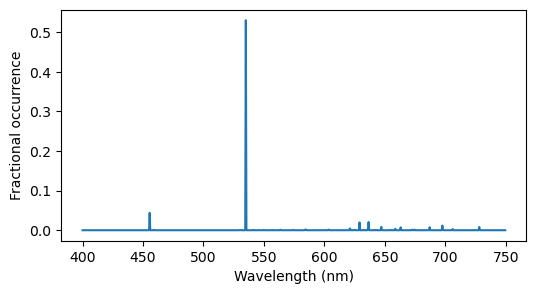

In [4]:
pyplot.figure(figsize = (6,3))
pyplot.plot(wvls, counts)
pyplot.xlabel('Wavelength (nm)')
pyplot.ylabel('Fractional occurrence')
pyplot.show()

The returned 'counts' are normalised to the number of iterations, so the line of height 0.5 at around 535 nm occurs over 50% of the time. This ensures that the absolute values returned aren't a function of number of iterations performed, and makes it easier to compare results. 

We can extend the range of wavelengths that we're interested in by specifying the `spectrum_range` parameter.

Time taken: 19.0 s


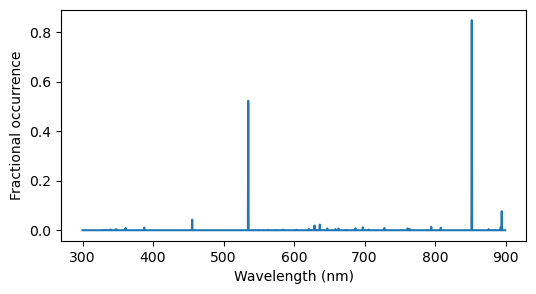

In [5]:
start_time = time.time()
wvls, counts = spec.calculate_spectrum((13,2,5/2), spectrum_range = (300,900), nmax = 100)
end_time = time.time()
print('Time taken: {:.1f} s'.format(end_time - start_time))

pyplot.figure(figsize = (6,3))
pyplot.plot(wvls, counts)
pyplot.xlabel('Wavelength (nm)')
pyplot.ylabel('Fractional occurrence')
pyplot.show()

Note that although there is a lot of fluorescence at 852nm, this is expected as it is the $\rm{D}_2$ transition in caesium.

To look at *all* the possible photons emitted/transitions we can just set a huge* range via the `spectrum_range` parameter. This is helpful if we're wanting to get information about the transition pathways or state populations using the `give_pops` or `give_paths` options.

\* There is no memory pre-allocation for arrays, so if the range is too big it will try and fill up all your RAM!

In [8]:
start_time = time.time()
wvls, counts, all_states, states_count, all_trans, trans_count = spec.calculate_spectrum(
    (13,2,5/2), nmax = 100, spectrum_range = (100, 1e7), give_pops = True, give_paths = True)
end_time = time.time()
print('Time taken: {:.1f} s'.format(end_time - start_time))

Time taken: 20.0 s


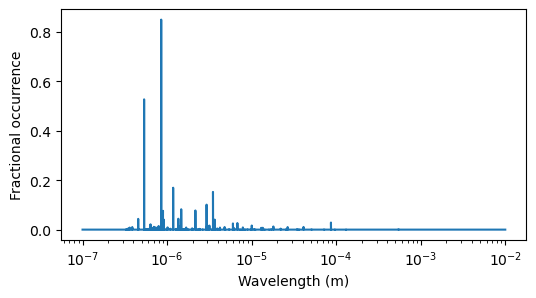

In [9]:
pyplot.figure(figsize = (6,3))
pyplot.plot(wvls*1e-9, counts)
pyplot.semilogx()
pyplot.xlabel('Wavelength (m)')
pyplot.ylabel('Fractional occurrence')
pyplot.show()

These options are useful for creating the decay pathway diagrams as seen in Fig. 3 of [[2]](#References).
The code would look something like the following:

In [10]:
import arc
atom = arc.Caesium()
pyplot.rcParams.update(pyplot.rcParamsDefault)
from matplotlib import cm #used to select a colourmap 

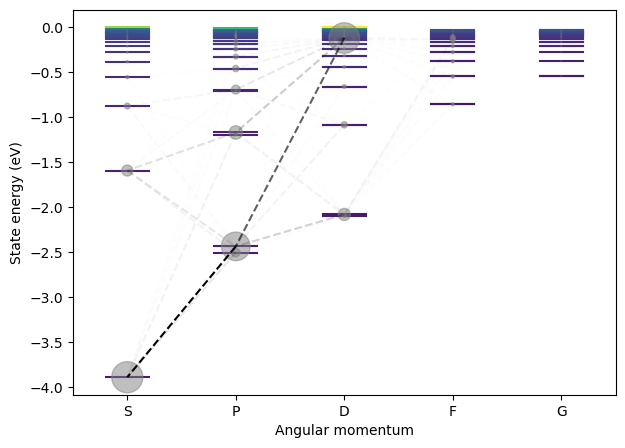

In [11]:
state_engs = numpy.zeros(len(all_states)) #create an empty array to store the state energies
for i in range(len(all_states)):
    #calculate the energy of each state visited in the simulation
    state_engs[i] = atom.getEnergy(int(all_states[i,0]), int(all_states[i,1]), all_states[i,2])

#do the same for the states in the transitions (there is redundancy here!)
trans_engs = numpy.zeros((len(all_trans),2))
for i in range(len(all_trans)):
    trans_engs[i,0] = atom.getEnergy(int(all_trans[i,0]), int(all_trans[i,1]), all_trans[i,2])
    trans_engs[i,1] = atom.getEnergy(int(all_trans[i,3]), int(all_trans[i,4]), all_trans[i,5])

fig, ax = pyplot.subplots(1,1,figsize = (7,5))
# for every state, plot a line corresponding to the energy of the state
#colour the lines according to the principal quantum number n 
for i in range(len(all_states)):
    ax.plot((all_states[i,1]-0.2, all_states[i,1]+0.2), (state_engs[i],state_engs[i]), 
    zorder = 0, c = cm.viridis(all_states[i,0]/numpy.max(all_states)))

#for every transition, plot a line between the initial and final state
#set the opacity of the line to be related to the number of times the transition occurs
for j in range(len(all_trans)):
    ax.plot((all_trans[j,1], all_trans[j,4]), (trans_engs[j,0], trans_engs[j,1]), 
    c = 'k', ls = 'dashed', alpha = trans_count[j]/numpy.max(trans_count))

#plot points representing the population passing through each state
#size of points represents the number of times they appear in the simulation
ax.scatter(all_states[:,1], state_engs, s = 500*states_count/numpy.max(states_count), alpha = 0.5, c = 'gray')

# label the x axis according to spectroscopic notation
max_l = int(numpy.max(all_states[:,1]))
l_labels = ['S','P','D','F','G','H','I']
ax.set_xticks(numpy.arange(max_l+1))
ax.set_xticklabels(l_labels[:max_l+1])

ax.set_xlim(-0.5,4.5)
ax.set_ylabel('State energy (eV)')
ax.set_xlabel('Angular momentum')
pyplot.show()

## References

[1] Lucy A. Downes et al., *Full-Field Terahertz Imaging at Kilohertz Frame Rates Using Atomic Vapor* Phys. Rev. X **10** 011027 (2020) [https://journals.aps.org/prx/abstract/10.1103/PhysRevX.10.011027](https://journals.aps.org/prx/abstract/10.1103/PhysRevX.10.011027)

[2] Lucy A. Downes, Lara Torralbo-Campo and Kevin J. Weatherill, *A practical guide to terahertz imaging using thermal atomic vapour* New J. Phys. **25** 035002 (2023) [https://iopscience.iop.org/article/10.1088/1367-2630/acb80c/meta](https://iopscience.iop.org/article/10.1088/1367-2630/acb80c/meta)

[3] Lucy A. Downes, *A High-speed THz Imaging System based on THz-to-optical Conversion in Atomic Vapour* PhD Thesis, Durham University (2020) [https://etheses.dur.ac.uk/13797/](https://etheses.dur.ac.uk/13797/)